# Evaluation

In this notebook the predictive performance of the QRNNs is evaluated against the NN-CTTH algorithm.

In [1]:
import utils.config
import numpy as np
import matplotlib.pyplot as plt

The data used for the evaluation is the *testing during development* from the CTTH article. Here it is stored in **data/*_test.npy** and the **_test** suffix is also used to name the corresponding variables.

In [7]:
x_train             = np.load("data/x_train.npy")
cloud_types_train   = np.load("data/cloud_types_train.npy")
x_test               = np.load("data/x_test.npy")
y_test               = np.load("data/y_test.npy")
y_test_pred          = np.load("data/y_test_pred.npy")
cloud_types_test     = np.load("data/cloud_types_test.npy")
y_test_pred[:, 0:2] /= 100.0

## Training and Evaluationset Distributions

/home/simon/src/matplotlib/lib/matplotlib/axes/_axes.py:6177: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


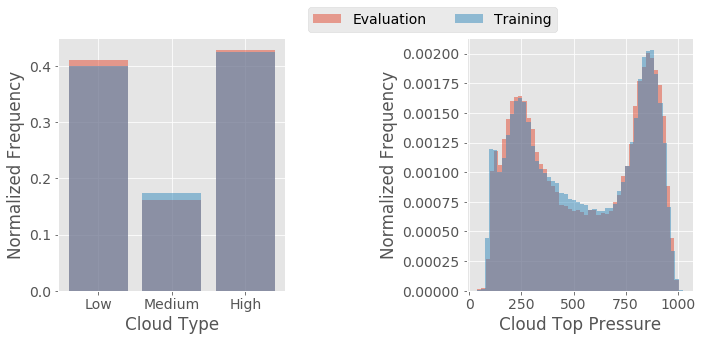

In [8]:
f, axs = plt.subplots(1, 2, figsize = (10, 5))
 
# Cloud type distribution
bins = np.array([-0.5, 0.5, 1.5, 2.5])
cloud_types_train = np.load("data/cloud_types_train.npy")
axs[0].hist(cloud_types_test, bins = bins, normed = True, rwidth = 0.8, alpha = 0.5, label = "Evaluation")
axs[0].hist(cloud_types_train, bins = bins, normed = True, rwidth = 0.8, alpha = 0.5, label = "Training")
axs[0].set_xticks([0, 1, 2])
axs[0].xaxis.set_ticklabels(["Low", "Medium", "High"])
axs[0].set_xlabel("Cloud Type")
axs[0].set_ylabel("Normalized Frequency")

# Cloud pressure distribution
y_train = np.load("data/y_train.npy")
axs[1].hist(y_test,  normed = True, alpha = 0.5, bins = 50, label = "Evaluation")
axs[1].hist(y_train, normed = True, alpha = 0.5, bins = 50, label = "Training")
axs[1].set_xlabel("Cloud Top Pressure")
axs[1].set_ylabel("Normalized Frequency")

axs.ravel()[1].legend(loc = 'upper center', bbox_to_anchor = (-0.15, 1.15),
                      fancybox = True, ncol = 3)

plt.tight_layout()
plt.savefig("plots/distributions_1.pdf")

/home/simon/src/matplotlib/lib/matplotlib/axes/_axes.py:6177: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


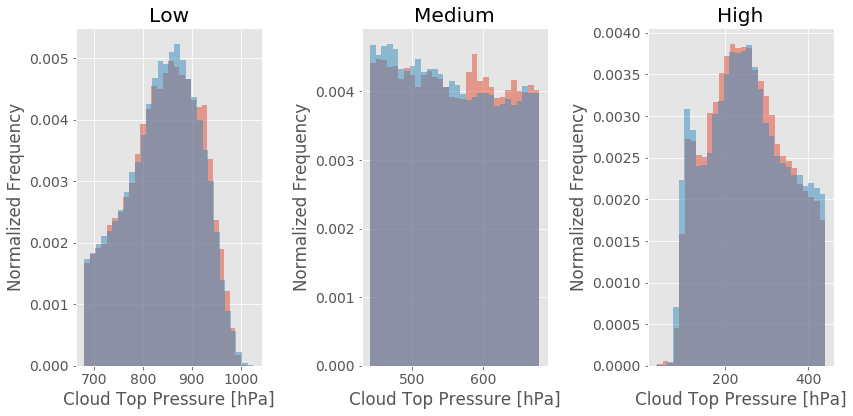

In [9]:
fig, axs = plt.subplots(1, 3, figsize = (12, 6))
labels = ["Low", "Medium", "High"]
for i in range(3):
    inds = cloud_types_test == i
    axs[i].hist(y_test[inds], bins = 30, normed = True, alpha = 0.5)
    inds = cloud_types_train == i
    axs[i].hist(y_train[inds], bins = 30, normed = True, alpha = 0.5)
    axs[i].set_xlabel("Cloud Top Pressure [hPa]")
    axs[i].set_ylabel("Normalized Frequency")
    axs[i].set_title(labels[i])
    
plt.tight_layout()    

## Models

In [4]:
%env KERAS_BACKEND=tensorflow
from typhon.retrieval.qrnn import QRNN
qrnn = QRNN.load("models/qrnn_4_64_ensemble_1_at_5")
y_pred_qrnn = qrnn.predict(x_test)

env: KERAS_BACKEND=tensorflow


Using TensorFlow backend.


FileNotFoundError: [Errno 2] No such file or directory: 'models/qrnn_4_64_ensemble_1_at_5'

In [ ]:
y_train = np.load("data/y_train.npy")
qrnn_ensemble = QRNN.load("models/qrnn_4_64_ensemble_5_at_5")
y_pred_qrnn_ensemble = qrnn_ensemble.predict(x_test)

## Results

/home/simonpf/build/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:819: RuntimeWarning: invalid value encountered in true_divide
  return n/(n*db).sum(), bins


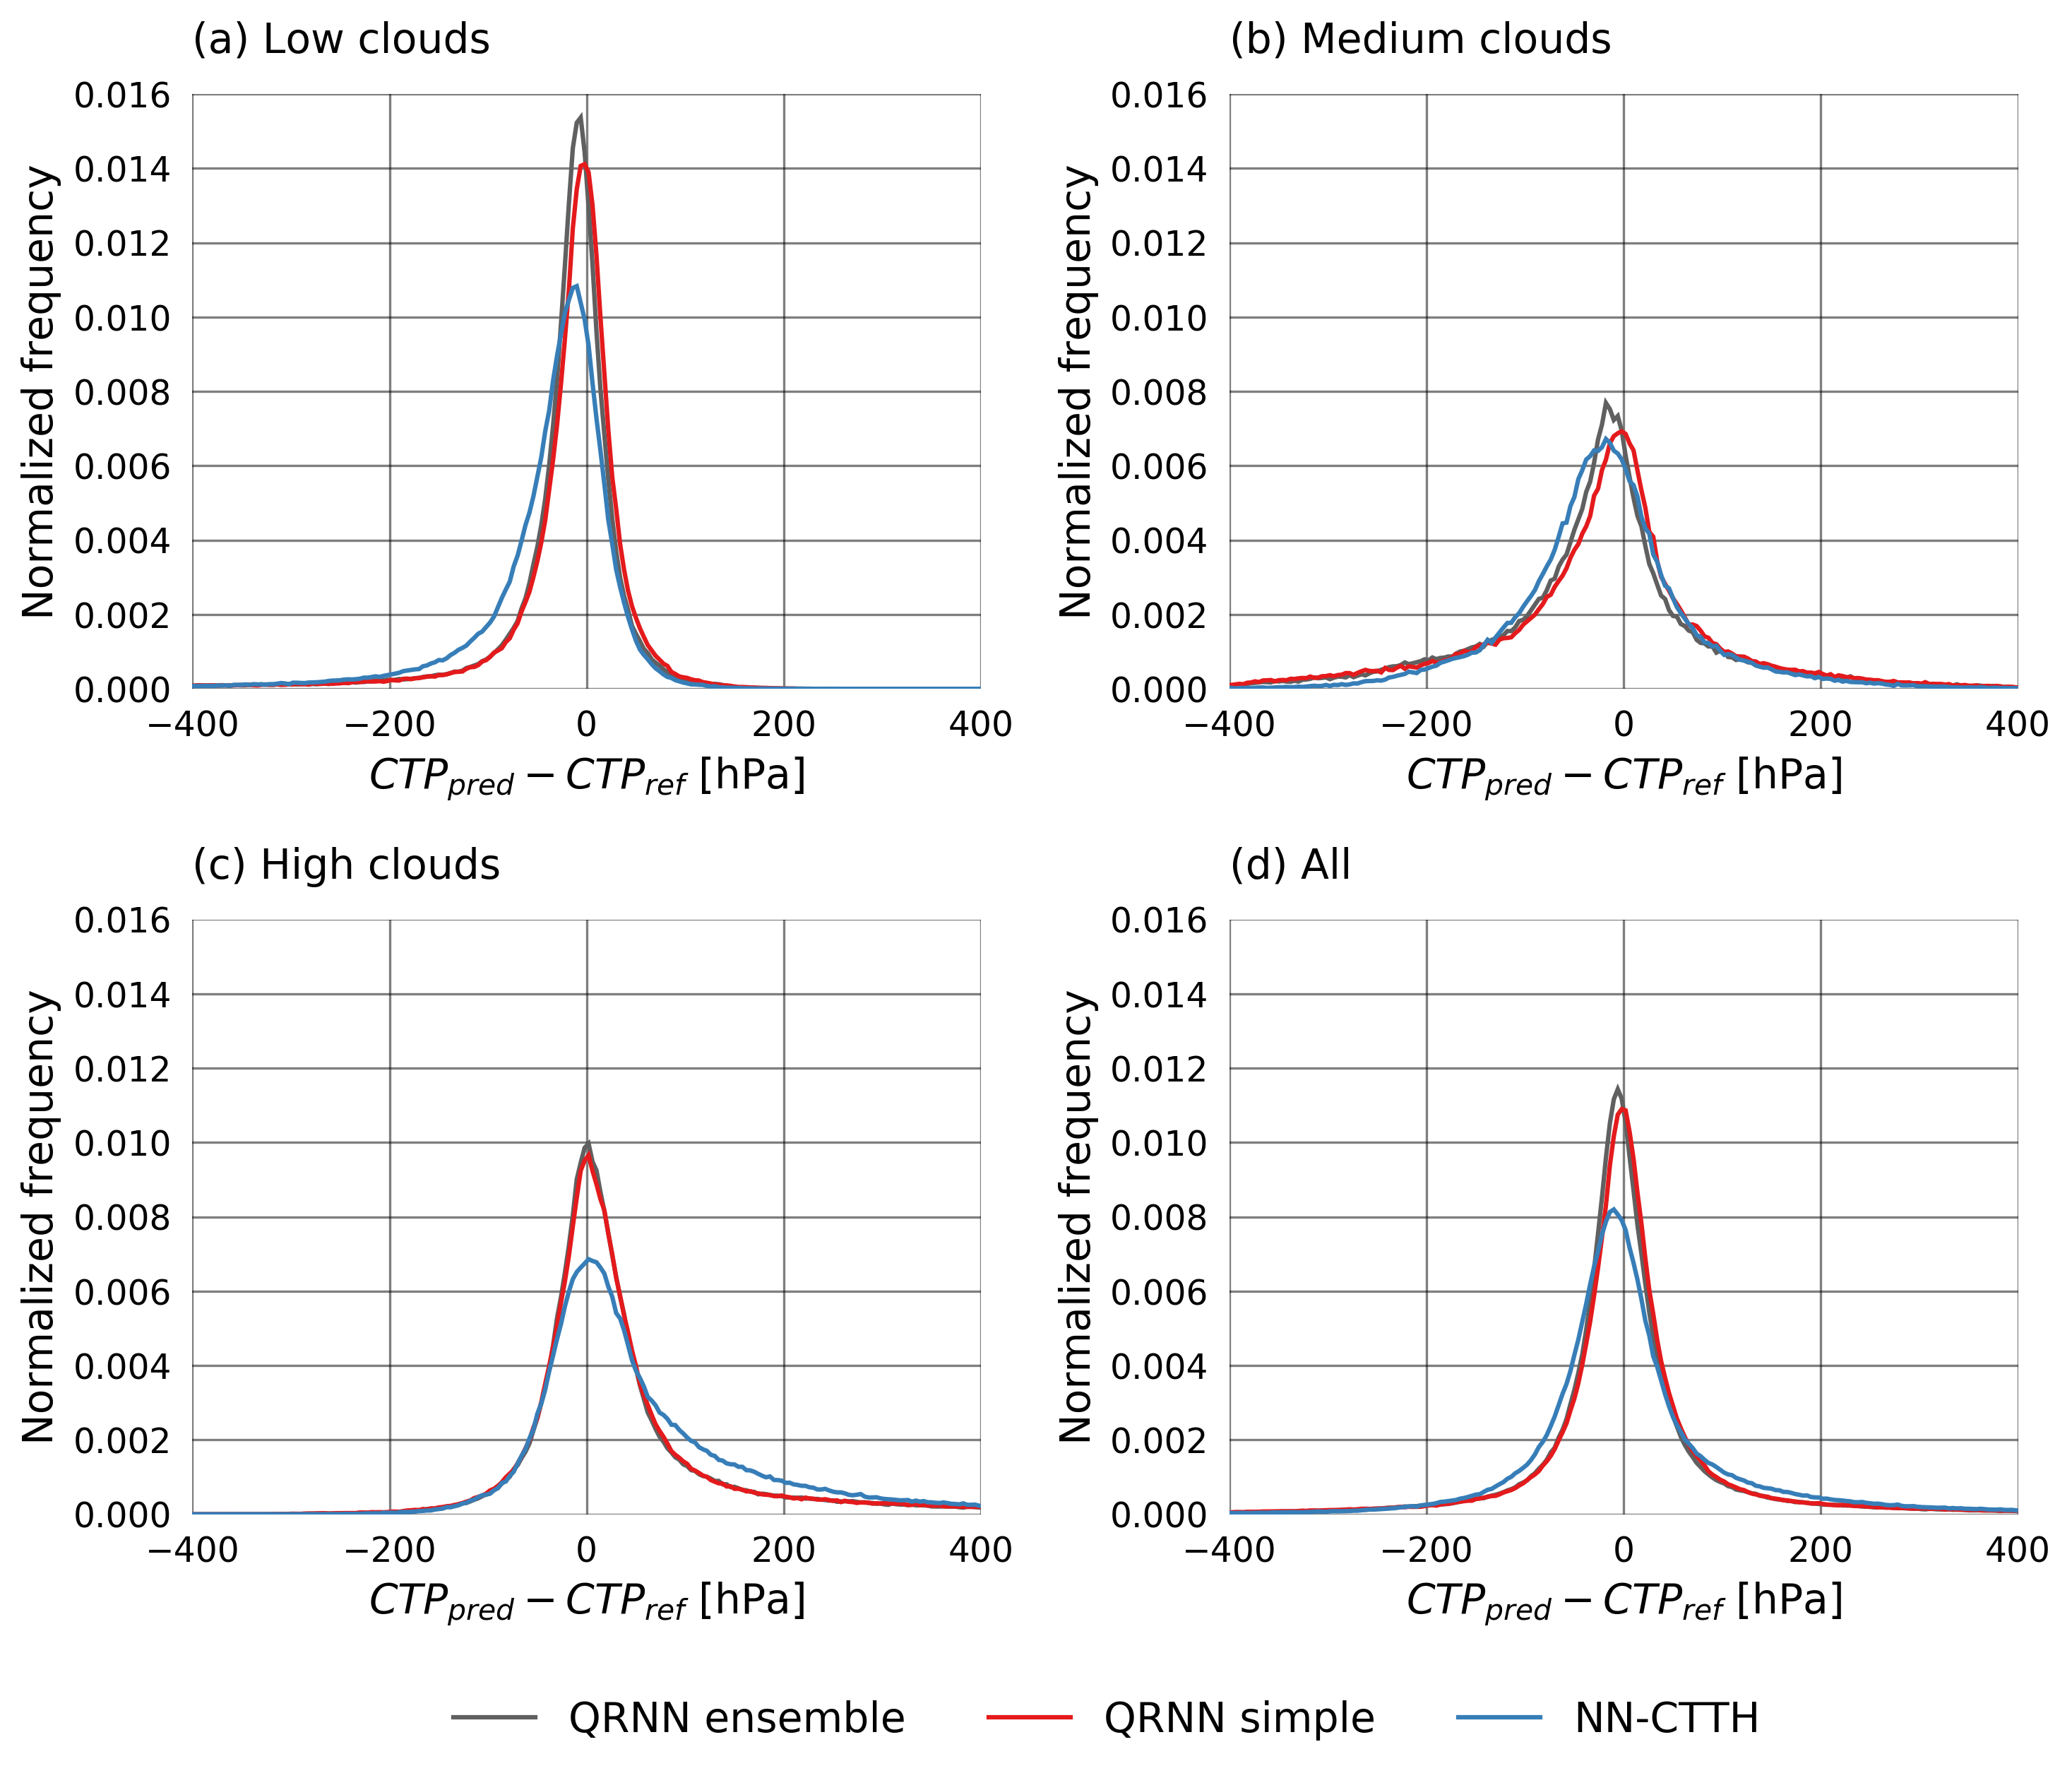

In [14]:
f, axs = plt.subplots(2, 2, figsize = (10, 8))
bins = np.linspace(-400.0, 400.0, 201)
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)
titles = ["(a) Low clouds", "(b) Medium clouds", "(c) High clouds", "(d) All"]

for i in range(3):
    inds = (cloud_types_test == i).ravel()
    inds *= inds_valid
    dy = y_test_pred[inds, :] - y_test[inds].reshape(-1, 1)
    ys_0, _ = np.histogram(dy[:, 0], bins = bins, normed = True)
    ys_1, _ = np.histogram(dy[:, 1], bins = bins, normed = True)
    ys_2, _ = np.histogram(dy[:, 2], bins = bins, normed = True)
    ys_3, _ = np.histogram(y_pred_qrnn[inds, 5] - y_test[inds].ravel(), bins = bins, normed = True)
    ys_4, _ = np.histogram(y_pred_qrnn_ensemble[inds, 5] - y_test[inds].ravel(), bins = bins, normed = True)
    xs = 0.5 * (bins[1:] + bins[:-1])
    c = 100.0 / inds.sum()
    
    ax_i = i // 2
    ax_j = i % 2
    axs[ax_i, ax_j].plot(xs, ys_4, label = "QRNN ensemble", lw = 1.5)
    axs[ax_i, ax_j].plot(xs, ys_3, label = "QRNN single", lw = 1.5)
    axs[ax_i, ax_j].plot(xs, ys_1, label = "NN-CTTH", lw = 1.5)
    axs[ax_i, ax_j].set_title(titles[i], loc = "left")
    axs[ax_i, ax_j].set_xlabel("$CTP_{pred} - CTP_{ref}$ [hPa]")
    axs[ax_i, ax_j].set_ylabel("Normalized frequency")
    axs[ax_i, ax_j].set_ylim([0.0, 0.016])
    axs[ax_i, ax_j].set_xlim([-400.0, 400.0])
    
    
dy = y_test_pred[:, :] - y_test.reshape(-1, 1)
ys_0, _ = np.histogram(dy[inds_valid, 0], bins = bins, normed = True)
ys_1, _ = np.histogram(dy[inds_valid, 1], bins = bins, normed = True)
ys_2, _ = np.histogram(dy[inds_valid, 2], bins = bins, normed = True)
ys_3, _ = np.histogram(y_pred_qrnn[inds_valid, 5] - y_test[inds_valid].ravel(), bins = bins, normed = True)
ys_4, _ = np.histogram(y_pred_qrnn_ensemble[inds_valid, 5] - y_test[inds_valid].ravel(), bins = bins, normed = True)
xs = 0.5 * (bins[1:] + bins[:-1])

ax_i = 1
ax_j = 1
axs[ax_i, ax_j].plot(xs, ys_4, label = "QRNN ensemble", lw = 1.5)
axs[ax_i, ax_j].plot(xs, ys_3, label = "QRNN simple", lw = 1.5)
axs[ax_i, ax_j].plot(xs, ys_1, label = "NN-CTTH", lw = 1.5)
axs[ax_i, ax_j].set_xlabel("$CTP_{pred} - CTP_{ref}$ [hPa]")
axs[ax_i, ax_j].set_ylabel("Normalized frequency")
axs[ax_i, ax_j].set_title(titles[3], loc = "left")
axs[ax_i, ax_j].set_ylim([0.0, 0.016])
axs[ax_i, ax_j].set_xlim([-400.0, 400.0])

axs.ravel()[3].legend(loc = 'best', bbox_to_anchor = (0.72, -0.25),
                      fancybox = True, ncol = 3)

plt.tight_layout()
f.savefig("./plots/ctp_results.pdf", bbox_inches = "tight")

In [15]:
biases = np.zeros(3)
maes   = np.zeros(3)
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)
biases[0]  = np.mean(y_pred_qrnn[inds_valid, 5] - y_test[inds_valid])
biases[1]  = np.mean(y_pred_qrnn_ensemble[inds_valid, 5] - y_test[inds_valid])
biases[2]  = np.mean(y_test_pred[inds_valid, 0] - y_test[inds_valid])
maes[0]    = np.mean(np.abs(y_pred_qrnn[inds_valid, 5] - y_test[inds_valid]))
maes[1]    = np.mean(np.abs(y_pred_qrnn_ensemble[inds_valid, 5] - y_test[inds_valid]))
maes[2]    = np.mean(np.abs(y_test_pred[inds_valid, 0] - y_test[inds_valid]))

cloud_biases = np.zeros((3, 3))
cloud_maes = np.zeros((3, 3))
for i in range(3):
    inds = (cloud_types_test == i).ravel()
    inds *= inds_valid
    cloud_biases[i, 0]  = np.mean(y_pred_qrnn[inds, 5] - y_test[inds])
    cloud_biases[i, 1]  = np.mean(y_pred_qrnn_ensemble[inds, 5] - y_test[inds])
    cloud_biases[i, 2]  = np.mean(y_test_pred[inds, 0] - y_test[inds])
    cloud_maes[i, 0]    = np.mean(np.abs(y_pred_qrnn[inds, 5] - y_test[inds]))
    cloud_maes[i, 1]    = np.mean(np.abs(y_pred_qrnn_ensemble[inds, 5] - y_test[inds]))
    cloud_maes[i, 2]    = np.mean(np.abs(y_test_pred[inds, 0] - y_test[inds]))
    
titles = ["Low Clouds", "Medium Clouds", "High Clouds"]
biases, cloud_biases, maes, cloud_maes

(array([  8.92426491,   6.09094954,  15.87410844]),
 array([[-27.89191628, -30.93143463, -32.95805502],
        [-23.37977028, -28.60061264, -15.49293098],
        [ 52.55792999,  50.76264954,  69.61971066]]),
 array([ 67.69896698,  65.85417938,  70.81716706]),
 array([[ 47.4903183 ,  46.69651031,  49.73152907],
        [ 82.69728851,  81.05444336,  65.33139586],
        [ 79.87772369,  77.04642487,  91.12604142]]))

## Uncertainty Estimation

To derive uncertainty estimates for the NN-CTTH algorithm, a Gaussian error is fitted to the mean squared error (MSE) and mean absolute error (MAE) on the evaluation set. 

The standard deviation of a Gaussian distribution with fixed MAE is can be obtained using:

$$
\mathcal{E}\{|X - \mu|\} = \sqrt{\frac{2}{\pi}} \sigma
$$

In [16]:
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)

mae = np.mean(np.abs(y_test_pred[inds_valid, [0]].ravel() - y_test[inds_valid]))
mse = np.var(y_test_pred[inds_valid, [0]].ravel() - y_test[inds_valid])

maes = np.zeros(3)
mses = np.zeros(3)

for i in range(3):
    inds = cloud_types_test == i
    inds *= inds_valid
    maes[i] = np.mean(np.abs(y_test_pred[inds, 0] - y_test[inds]))
    mses[i] = np.var(y_test_pred[inds, 0] - y_test[inds])
    
sigma_mae  = np.sqrt(np.pi / 2.0) * mae
sigmas_mae = np.sqrt(np.pi / 2.0) * maes
sigma_mse  = np.sqrt(mse)
sigmas_mse = np.sqrt(mses)

In [189]:
mae_qrnn = np.mean(np.abs((y_pred_qrnn[inds_valid, 5] - y_test[inds_valid])))
mae_qrnn_ensemble = np.mean(np.abs((y_pred_qrnn_ensemble[inds_valid, 5] - y_test[inds_valid])))
mae_qrnn, mae_qrnn_ensemble

(67.698967, 65.854179)

### Sampling the Posterior

To test how well the predicted posteriors estimate the observed error, we generate a sample from each retrieved posterior distribution and compare this against the observed error.

In [ ]:
n  = y_test.shape[0]
dp_qrnn = np.zeros(n)
dp_qrnn_ensemble = np.zeros(n)

for i in range(n):
    p = qrnn.sample_posterior(x_test[i, :])
    dp_qrnn[i] = p - y_pred_qrnn[i, 5]
    p = qrnn_ensemble.sample_posterior(x_test[i, :])
    dp_qrnn_ensemble[i] = p - y_pred_qrnn_ensemble[i, 5]
    if i % 100000 == 0:
        print("progress: " + str(i))

progress: 0
progress: 100000
progress: 200000
progress: 300000
progress: 400000
progress: 500000
progress: 600000
progress: 700000
progress: 800000


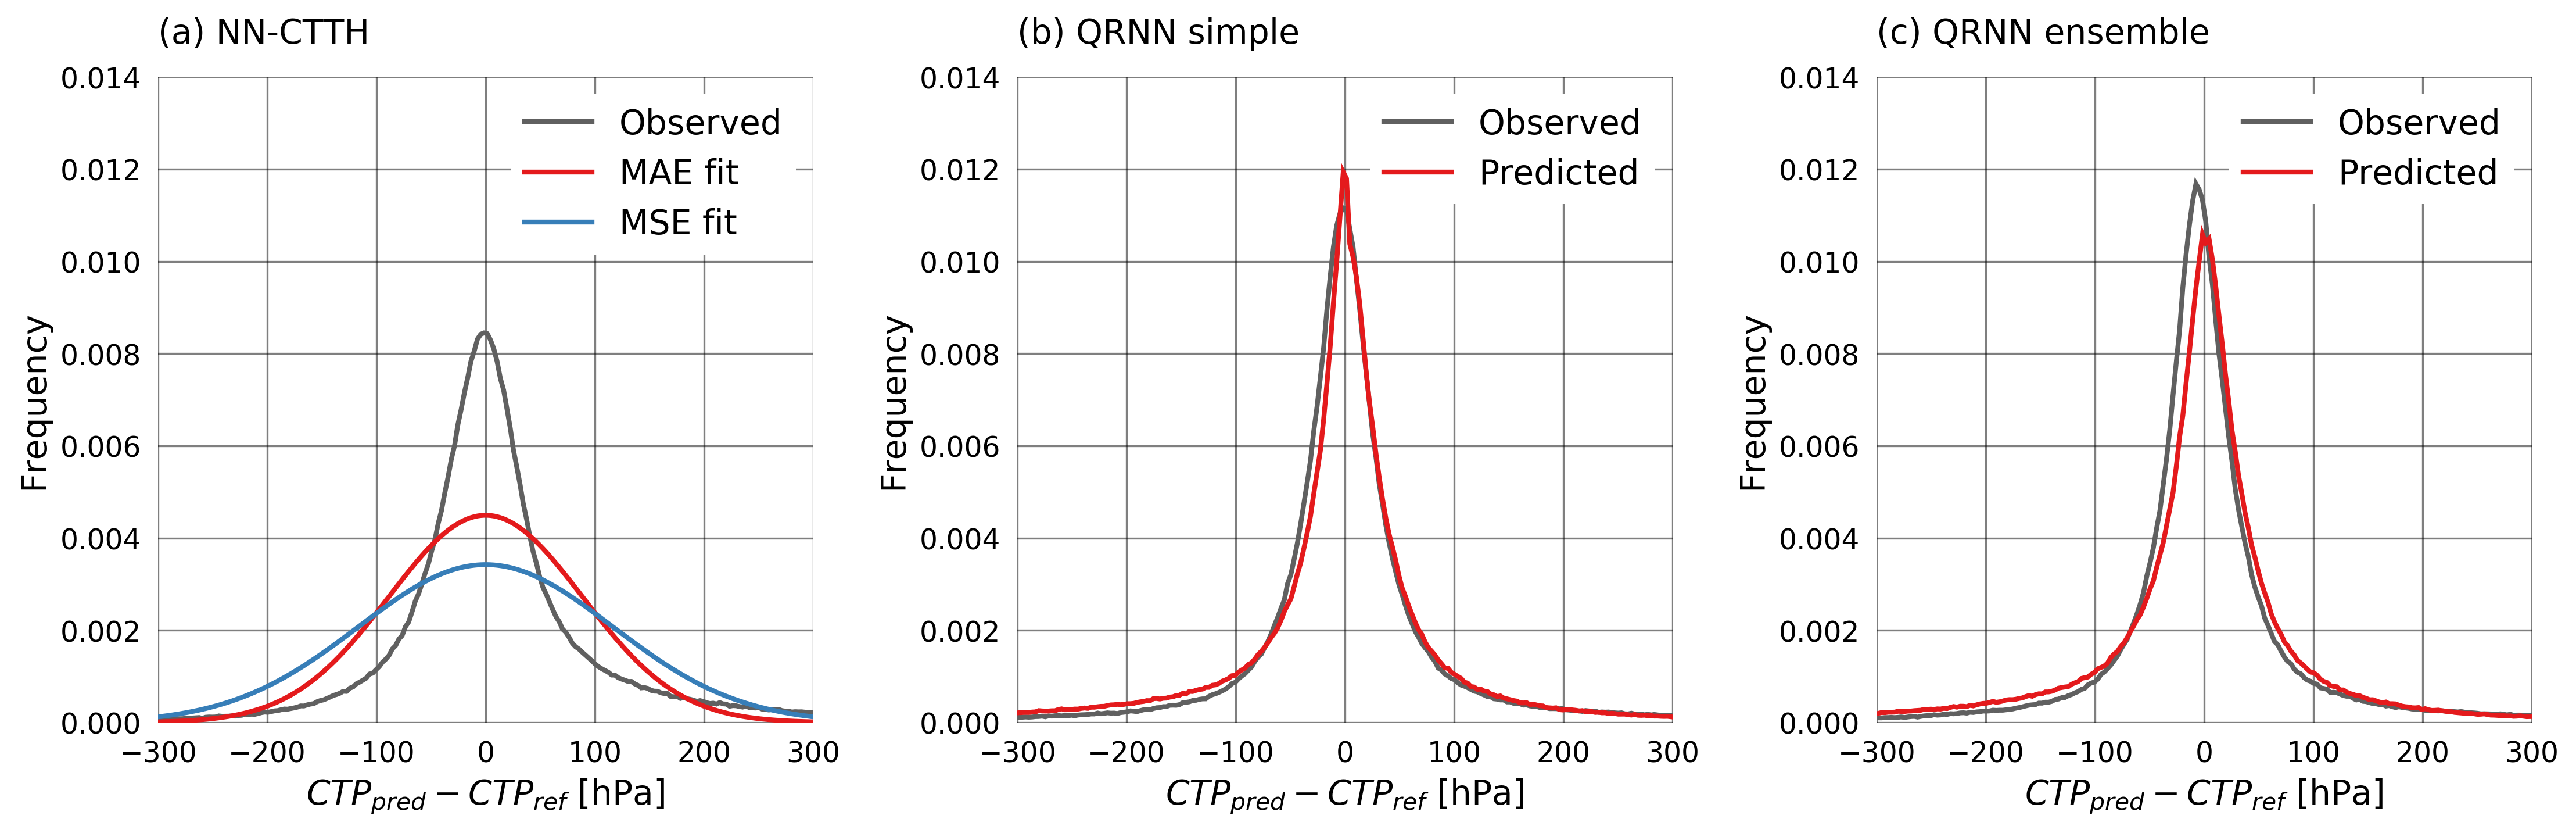

In [20]:
from scipy.stats import norm

f, axs = plt.subplots(1, 3, figsize = (15, 5))
bins = np.linspace(-300.0, 300.0, 201)
xs = 0.5 * (bins[1:] + bins[:-1])
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)

dy    = y_test_pred[inds_valid, 0] - y_test[inds_valid]
ys, _ = np.histogram(dy, bins = bins, normed = True)

axs[0].plot(xs, ys, label = "Observed", lw = 2)
axs[0].plot(xs, norm.pdf(xs, scale = sigma_mae), label = "MAE fit", lw = 2)
axs[0].plot(xs, norm.pdf(xs, scale = sigma_mse), label = "MSE fit", lw = 2)
axs[0].set_title("(a) NN-CTTH", loc = "left")
axs[0].legend()
axs[0].set_xlabel("$CTP_{pred} - CTP_{ref}$ [hPa]")
axs[0].set_ylabel("Frequency")
axs[0].set_xlim([-300, 300])
axs[0].set_ylim([0, 0.014])

ys, _ = np.histogram(y_pred_qrnn[inds_valid, 5] - y_test[inds_valid], bins = bins, normed = True)
axs[1].plot(xs, ys, label = "Observed", lw = 2)
ys, _ = np.histogram(dp_qrnn, bins = bins, normed = True)
axs[1].plot(xs, ys, label = "Predicted", lw = 2)
axs[1].set_title("(b) QRNN simple", loc = "left")
axs[1].legend()
axs[1].set_xlabel("$CTP_{pred} - CTP_{ref}$ [hPa]")
axs[1].set_ylabel("Frequency")
axs[1].set_xlim([-300, 300])
axs[1].set_ylim([0, 0.014])

ys, _ = np.histogram(y_pred_qrnn_ensemble[inds_valid, 5] - y_test[inds_valid],
                     bins = bins,
                     normed = True)
axs[2].plot(xs, ys, label = "Observed", lw = 2)
ys, _ = np.histogram(dp_qrnn_ensemble, bins = bins, normed = True)
axs[2].plot(xs, ys, label = "Predicted", lw = 2)
axs[2].set_title("(c) QRNN ensemble", loc = "left")
axs[2].legend()
axs[2].set_xlabel("$CTP_{pred} - CTP_{ref}$ [hPa]")
axs[2].set_ylabel("Frequency")
axs[2].set_xlim([-300, 300])
axs[2].set_ylim([0, 0.014])

plt.tight_layout()
f.savefig("plots/ctp_error_fit.pdf", bbox_inches = "tight")

## Calibration

To test the calibration of the predictions, a calibration plot is generated using prediction intervals derived from the QRNN predictions as well as from the Gaussian fits to the NN-CTTH error.

In [21]:
from scipy.stats import norm

alphas = 0.1 * np.arange(1, 10, 2)
interval = norm.interval(alphas, scale = sigma_mae)[1]

intervals = np.zeros((3, 5))
for i in range(3):
    intervals[i, :] = norm.interval(alphas, scale = sigmas_mae[i])[1]

In [22]:
y_pred_l = np.zeros((y_test.shape[0], 5))
y_pred_r = np.zeros((y_test.shape[0], 5))
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)

for i in range(5):
    y_pred_l[inds_valid, i] = (y_test_pred[inds_valid,  [0]] - interval[i]).ravel()
    y_pred_r[inds_valid, i] = (y_test_pred[inds_valid, [0]] + interval[i]).ravel()
    
fractions_naive = np.zeros(5)
for i in range(5):
    inds = ((y_pred_l[:, i] < y_test.ravel()) * (y_pred_r[:, i] > y_test.ravel()))
    inds = inds[inds_valid]
    fractions_naive[i] = np.mean(inds)

In [23]:
fractions = np.zeros(5)
fractions_ensemble = np.zeros(5)
inds_valid = np.all(y_test_pred[:, [0]] > 0.0, axis = 1)
inds_lt = y_test[inds_valid].reshape(-1, 1) < y_pred_qrnn[inds_valid, :]
inds_gt = y_test[inds_valid].reshape(-1, 1) > y_pred_qrnn[inds_valid, :]
inds_lt_ensemble = y_test[inds_valid].reshape(-1, 1) < y_pred_qrnn_ensemble[inds_valid, :]
inds_gt_ensemble = y_test[inds_valid].reshape(-1, 1) > y_pred_qrnn_ensemble[inds_valid, :]

for i in range(5):
    fractions[i] = np.mean(inds_gt[:, 4 - i] * inds_lt[:, 6 + i])
    fractions_ensemble[i] = np.mean(inds_gt_ensemble[:, 4 - i] * inds_lt_ensemble[:, 6 + i])
    

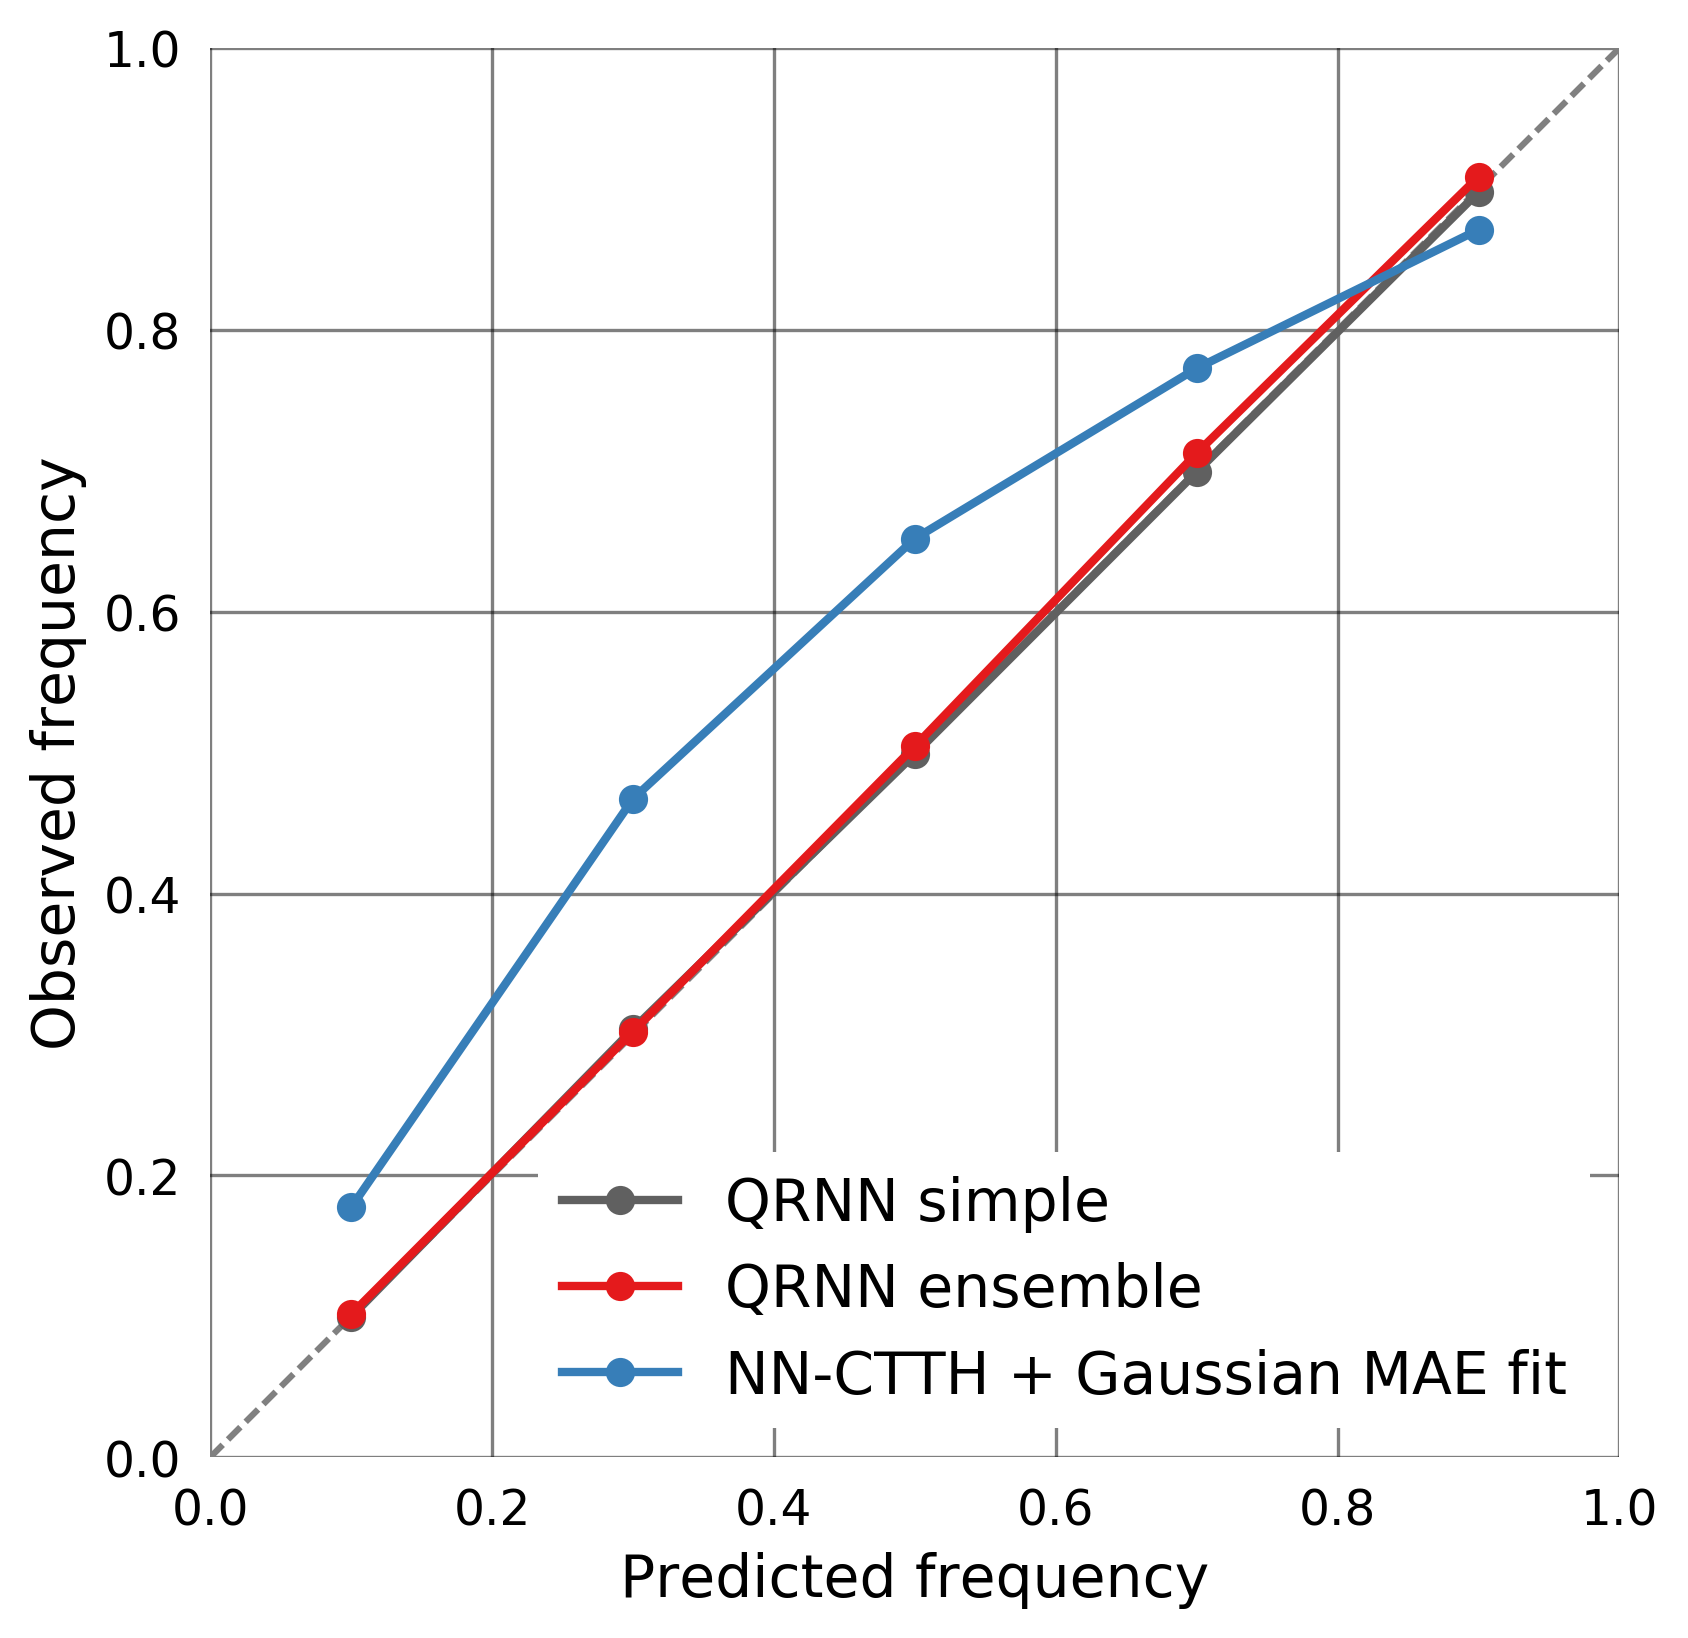

In [24]:
xs = np.arange(0.0, 1.1, 0.1)
plt.figure(figsize = (6.1,6.1))
plt.plot(xs, xs, c = 'grey', ls = '--')
xs = 0.1 * np.arange(1, 10, 2)
plt.plot(xs, fractions, lw = 2, label = "QRNN simple", marker = 'o')
plt.plot(xs, fractions_ensemble, lw = 2, label = "QRNN ensemble", marker = 'o')
plt.plot(xs, fractions_naive, lw = 2, label = "NN-CTTH + Gaussian MAE fit", marker = 'o')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("Predicted frequency")
plt.ylabel("Observed frequency")
plt.legend()
plt.savefig("plots/calibration_1.pdf")
plt.gca().set_aspect(1)

### Calibration by cloud type

Finally, the calibration is considered separately for each cloud type.

In [25]:
fractions = np.zeros((3, 5))
for i in range(3):
    inds = (cloud_types_test == i) * inds_valid
    inds_lt = y_test[inds].reshape(-1, 1) < y_pred_qrnn[inds, :]
    inds_gt = y_test[inds].reshape(-1, 1) > y_pred_qrnn[inds, :]

    for j in range(5):
        fractions[i, j] = np.mean(inds_gt[:, 4 - j] * inds_lt[:, 6 + j])

In [26]:
fractions_naive = np.zeros((3, 5))

for i in range(3):
    inds_valid_clouds = (cloud_types_test == i) * inds_valid
    for j in range(5):
        y_pred_l = (y_test_pred[:, 0] - interval[j]).ravel()
        y_pred_r = (y_test_pred[:, 0] + interval[j]).ravel()
        inds = ((y_pred_l < y_test.ravel()) * (y_pred_r > y_test.ravel()))
        inds = inds[inds_valid_clouds]
        fractions_naive[i, j] = np.mean(inds)

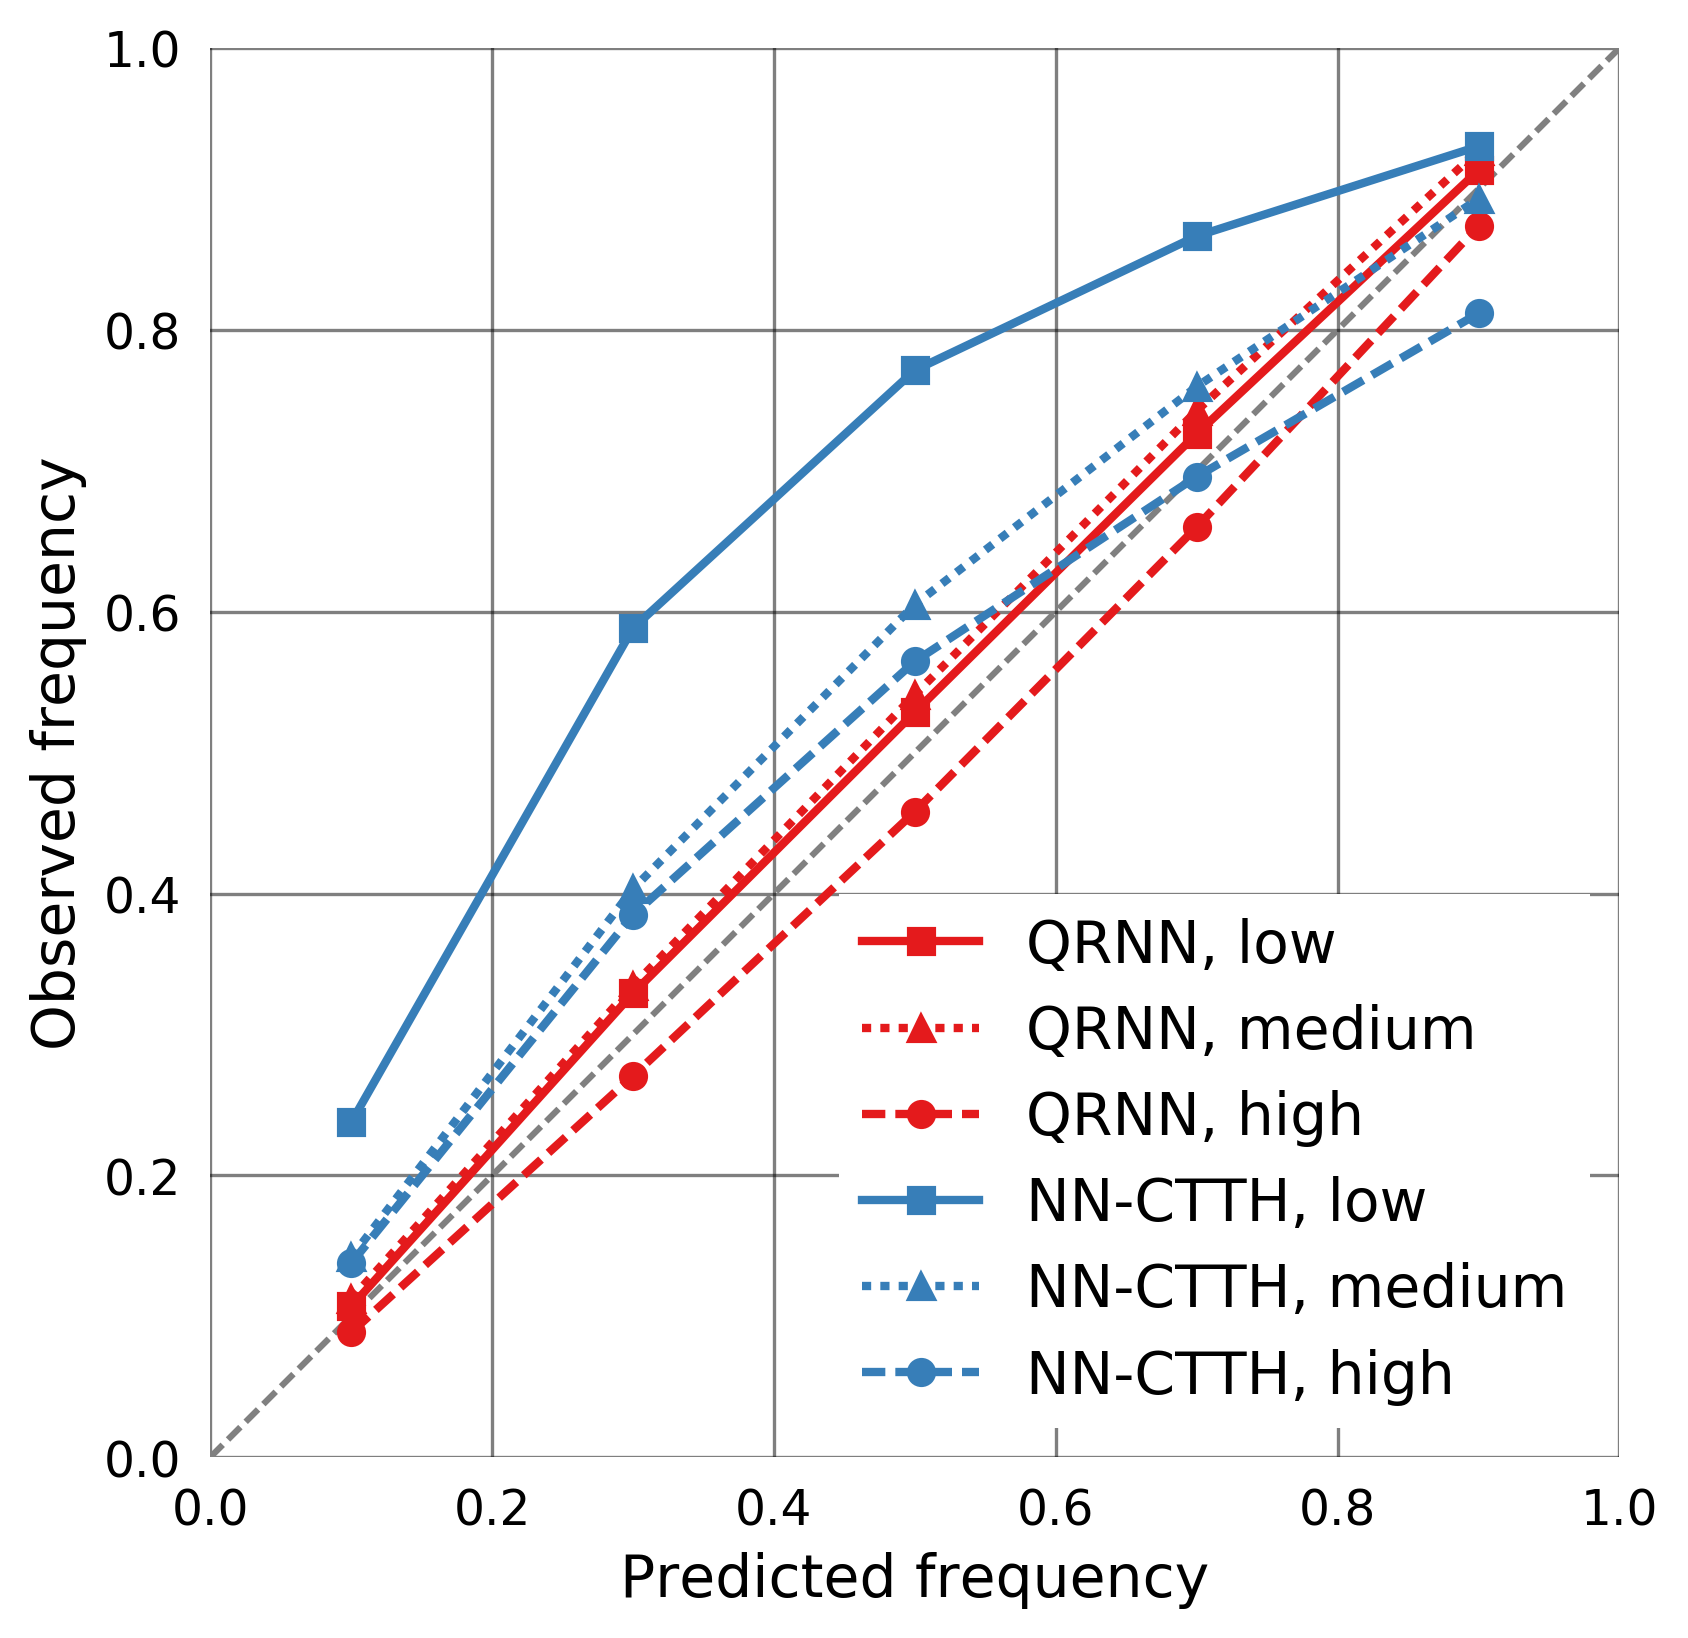

In [27]:
f, ax = plt.subplots(1, 1, figsize = (6.1, 6.1))
xs = np.arange(0.0, 1.1, 0.1)
ax.plot(xs, xs, c = 'grey', ls = '--')
xs = 0.1 * np.arange(1, 10, 2)
ax.plot(xs, fractions[0, :], lw = 2, c = "C1", ls = "-", label = "QRNN, low", marker = "s")
ax.plot(xs, fractions[1, :], lw = 2, c = "C1", ls = ":", label = "QRNN, medium", marker = "^")
ax.plot(xs, fractions[2, :], lw = 2, c = "C1", ls = "--", label = "QRNN, high", marker = "o")
ax.plot(xs, fractions_naive[0, :], lw = 2, c = "C2", ls = "-", label = "NN-CTTH, low", marker = "s")
ax.plot(xs, fractions_naive[1, :], lw = 2, c = "C2", ls = ":", label = "NN-CTTH, medium", marker = "^")
ax.plot(xs, fractions_naive[2, :], lw = 2, c = "C2", ls = "--", label = "NN-CTTH, high", marker = "o")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")
ax.legend(ncol = 1)
ax.set_aspect(1)
f.savefig("plots/calibration_cloud_type.pdf", bbox_inches = "tight")